In [1]:
import pandas as pd
import glob
import numpy as np
import os
import json
import scipy.io
import shutil
import re

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib
from PIL import Image
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("ticks")

import collections

def parse_results(glob_path,no_log=True):
    print("parsing",glob_path)
    table = []
    for path_ori in glob.glob(glob_path):
        #history = json.load(open(path))
        exp_dir = os.path.split(path_ori)[0]
        
        opt = {}
        path = os.path.join(exp_dir,"args.json")
        if os.path.exists(path):
            try:
                opt = json.load(open(path))
            except:
                print(path)
        else:
            print("not found:",path)
            continue
            
        opt["exp"] = path_ori
        log = json.load(open(path_ori))

        acc = -1
        if "test" in log:
            acc = log["test"]['acc']
        else:
            continue
            
        path = os.path.join(exp_dir,"log_infer.json")
        infer = None
        if os.path.exists(path):
            try:
                infer = json.load(open(path))
            except:
                print("error",path)
        else:
            #print("not found:",path)
            pass

        opt["acc"] = acc
        opt["iters"] = len(log["train"])
        opt["best_acc"] = log['best_acc']
        opt["best_epoch"] = log['best_epoch']
        opt["time_elapsed"] = log['time_elapsed']
        opt["log"] = log
        opt['infer'] = infer
        table.append(opt)
    df_results = pd.DataFrame(table)
    return df_results[sorted(df_results.columns)]

#https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [2]:
train_txt_subset_mapping = {'naiming_3s_whole_img_acuity.txt': 'acuity original',
 'naiming_3s_whole_img_acuity_num-1100.txt': 'original acuity num-1100',
 'naiming_3s_whole_img_acuity_num-1100-parent.txt': 'original acuity num-1100 parent',
 'naiming_3s_whole_img_acuity_parent.txt': 'acuity original parent',
 'naiming_3s_whole_img_acuity_num-50.txt': 'original acuity num-50',
 'naiming_3s_whole_img_acuity_num-100.txt': 'original acuity num-100',
 'naiming_3s_whole_img_acuity_num-200.txt': 'original acuity num-200',
 'naiming_3s_whole_img_acuity_num-400.txt': 'original acuity num-400',
 'naiming_3s_whole_img_acuity_num-600.txt': 'original acuity num-600',
 'naiming_3s_whole_img_acuity_num-800.txt': 'original acuity num-800',
 'naiming_3s_whole_img_acuity_concentrated_0.60.txt': 'concentrated acuity original',
 'naiming_3s_whole_img_acuity_scattered_0.60.txt': 'scattered acuity original',
 'naiming_3s_whole_img_acuity_concentrated_looked_0.60.txt': 'concentrated_looked acuity original',
 'naiming_3s_whole_img_acuity_concentrated_not-looked_0.60.txt': 'concentrated_not-looked acuity original',
 'naiming_3s_whole_img_acuity_large_0.06.txt': 'large acuity original',
 'naiming_3s_whole_img_acuity_small_0.06.txt': 'small acuity original',
 'naiming_3s_whole_img_acuity_small_concentrated_1.00.txt': 'small_concentrated acuity original',
 'naiming_3s_whole_img_acuity_small_scattered_1.00.txt': 'small_scattered acuity original',
 'naiming_3s_whole_img_acuity_large_scattered_1.00.txt': 'large_scattered acuity original',
 'naiming_3s_whole_img_acuity_large_concentrated_1.00.txt': 'large_concentrated acuity original',
 'naiming_3s_whole_img_acuity_num-50-parent.txt': 'original acuity num-50 parent',
 'naiming_3s_whole_img_acuity_num-800-parent.txt': 'original acuity num-800 parent',
 'naiming_3s_whole_img_acuity_num-100-parent.txt': 'original acuity num-100 parent',
 'naiming_3s_whole_img_acuity_num-200-parent.txt': 'original acuity num-200 parent',
 'naiming_3s_whole_img_acuity_num-400-parent.txt': 'original acuity num-400 parent',
 'naiming_3s_whole_img_acuity_num-600-parent.txt': 'original acuity num-600 parent'}

In [3]:
glob_path = "../experiments/cogsci2020-reported/*/log.json"
df_results = parse_results(glob_path)
df_results["subset"] = df_results["train"].apply(lambda x:train_txt_subset_mapping[os.path.basename(x)])

parsing ../experiments/cogsci2020-reported/*/log.json


# Study 1: Learning object names from raw egocentric video

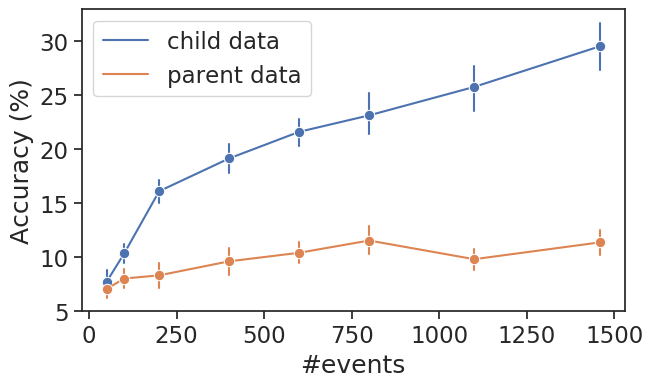

In [4]:
ci = 95
num_view_map = {}
num_map = {}
num_map_acuity = {}

num_map["naiming_3s_whole_img.txt"] = 1459
num_map_acuity["naiming_3s_whole_img_acuity.txt"] = 1459
num_map["naiming_3s_whole_img_parent.txt"] = 1459
num_map_acuity["naiming_3s_whole_img_acuity_parent.txt"] = 1459

num_view_map["naiming_3s_whole_img.txt"] = 'child'
num_view_map["naiming_3s_whole_img_acuity.txt"] = 'child'
num_view_map["naiming_3s_whole_img_parent.txt"] = 'parent'
num_view_map["naiming_3s_whole_img_acuity_parent.txt"] = 'parent'   

for view in ["parent","child"]:    
    for num in [50,100,200,400,600,800,1100]:
        key = "num-%d"%num        
        txt_name = "naiming_3s_whole_img_acuity_%s.txt"%key
        if view == 'parent':
            txt_name = "naiming_3s_whole_img_acuity_%s-parent.txt"%key
        num_view_map[txt_name] = view
        num_map_acuity[txt_name] = num

df_results["txtname"] = df_results["train"].apply(lambda x:os.path.basename(x))
df_num = []
for i,row in df_results.iterrows():
    txtname = row["txtname"]
    if txtname in num_map_acuity:
        row["num"] = num_map_acuity[txtname]
        row['view'] = num_view_map[txtname]
        row["type"] = "acuity whole"
        df_num.append(row)
df_num = pd.DataFrame(df_num)
df_num["acc"] = df_num['acc']*100
df_num = df_num.query("type=='acuity whole' and seed < 11")

df_num['subset'].unique()

df_num = df_num.query("type=='acuity whole' and seed < 11")

fig = plt.figure(dpi=100,figsize=(7,4))
ax = sns.lineplot(x="num", y="acc", hue="view", data=df_num ,ci=ci,err_style="bars",marker=".",markersize=15,hue_order=["child","parent"])
#ax = sns.lineplot(x="num", y="acc", hue="view",style="type", data=df_num, marker=".",markersize=15, dashes=False ,ci=ci,err_style="bars")
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=[handles[i] for i in [1,2,4,5]],
#           labels=[labels[i] for i in [1,2,4,5]],
#           bbox_to_anchor=(0.5, -0.2),ncol=2,loc='upper center'
#          )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:],
          labels=["child data","parent data"],
         )
plt.xlabel("#events")
plt.ylabel("Accuracy (%)")
# plt.ylim(0,50)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

plt.savefig("../results/study1num.pdf",bbox_inches='tight', pad_inches = 0)

plt.show()

## Study 2: Examining the effects of different attentional strategies

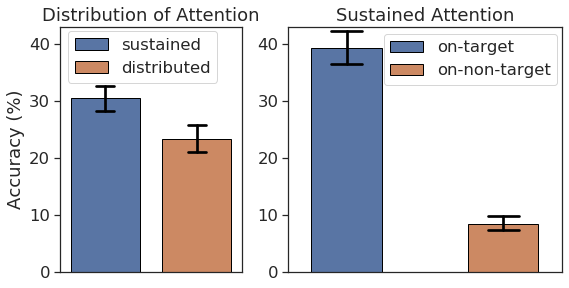

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(9, 4.5))
gs = gridspec.GridSpec(1, 2,width_ratios=[1,1.5])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1])]

#study 3
select_map = collections.OrderedDict({"concentrated acuity original":"acuity\n whole",
                                      "scattered acuity original":"acuity\n whole"})
def split(x):
    if x.find('concentrated') >= 0:
        return "sustained"
    if x.find('scattered') >= 0:
        return "distributed"
    
df_results_select = df_results[df_results["subset"].isin(select_map.keys())].copy()
df_results_select["accuracy"] = df_results_select["acc"]*100
df_results_select["name"] = df_results_select["subset"].map(select_map)
df_results_select["temporal attention"] = df_results_select["subset"].apply(split)

# fig = plt.figure(dpi=100,figsize=(3,6))
ax = sns.barplot(x="name",y="accuracy",hue='temporal attention', data=df_results_select,ci=ci,
                 order = list(select_map.values())[1:5],palette=sns.color_palette(),
                 edgecolor='black',capsize=0.08,errcolor="black",hue_order = ['sustained','distributed'],ax=axes[0],
                )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
          labels=["sustained","distributed"],
          bbox_to_anchor=(0, 0.74),
          loc='lower left',ncol=1,
         )
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
# ax.legend(loc='upper right',ncol=1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xticks([])
change_width(ax, .30)
ax.set_xlabel(None)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0,43)
ax.set_xlim(-0.4,+0.4)
ax.set_title("Distribution of Attention")

# plt.savefig("../results/StudyAttStrategy.pdf",bbox_inches='tight', pad_inches = 0)
# plt.show()


#study 3c
select_map = collections.OrderedDict({"concentrated_looked acuity original":"acuity\nwhole",
                                      "concentrated_not-looked acuity original":"acuity\nwhole"})
def split(x):
    if x.find('concentrated_looked') >= 0:
        return "sustained looked"
    if x.find('concentrated_not-looked') >= 0:
        return "sustained not looked"
    
df_results_select = df_results[df_results["subset"].isin(select_map.keys())].copy()
df_results_select["accuracy"] = df_results_select["acc"]*100
df_results_select["name"] = df_results_select["subset"].map(select_map)
df_results_select["looked"] = df_results_select["subset"].apply(split)

# fig = plt.figure(dpi=100,figsize=(6,6))
ax = sns.barplot(x="name",y="accuracy",hue='looked', data=df_results_select,ci=ci,
                 order = list(select_map.values())[1:5],palette=sns.color_palette(),
                 edgecolor='black',capsize=0.08,errcolor="black",ax=axes[1])
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
          labels=["on-target","on-non-target"],
          bbox_to_anchor=(0.32, 0.73),
          loc='lower left',ncol=1,
         )
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xticks([])
change_width(ax, .18)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_ylim(0,43)
ax.set_xlim(-0.35,+0.35)
ax.set_title("Sustained Attention")
plt.savefig("../results/StudyAtt.pdf",bbox_inches='tight', pad_inches = 0)
plt.show()

# Study 3 Examining the effects of visual properties of attended objects

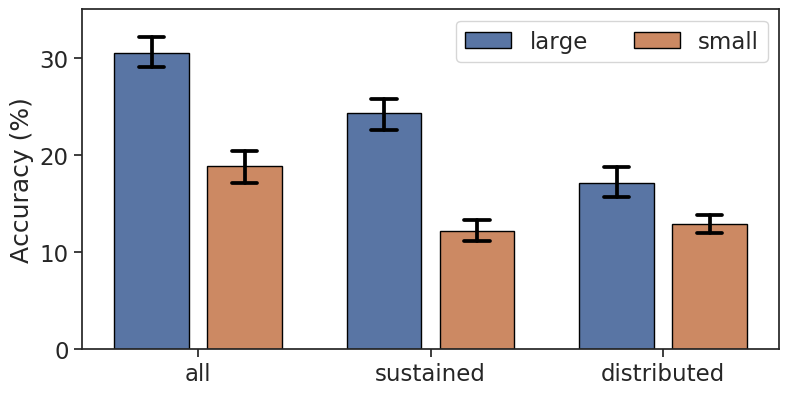

In [6]:
select_map = collections.OrderedDict({"large acuity original":"acuity\nwhole",
                                      "small acuity original":"acuity\nwhole"})

def split(x):
    if x.find('large') >= 0:
        return "large"
    if x.find('small') >= 0:
        return "small"
    
df_results_select = df_results[df_results["subset"].isin(select_map.keys())].copy()
df_results_select["accuracy"] = df_results_select["acc"]*100
df_results_select["name"] = "all"
df_results_select["size"] = df_results_select["subset"].apply(split)
df_results_select_copy = df_results_select
 
select_names1 = ["large_concentrated original",
                  "small_concentrated original",
                  "large_scattered original",
                  "small_scattered original",
                ]

select_names2 = [ "large_concentrated acuity original",
                  "small_concentrated acuity original",
                  "large_scattered acuity original",
                  "small_scattered acuity original",
                ]

selects = [select_names1,select_names2]

def split1(x):
    if x.find('large') >= 0:
        return "large"
    if x.find('small') >= 0:
        return "small"
    
def split2(x):
    if x.find('concentrated') >= 0:
        return "sustained"
    if x.find('scattered') >= 0:
        return "distributed"
i = 1
df_results_select = df_results[df_results["subset"].isin(selects[i])].copy()
df_results_select["accuracy"] = df_results_select["acc"]*100
df_results_select["size"] = df_results_select["subset"].apply(split1)
df_results_select["name"] = df_results_select["subset"].apply(split2)
df_results_select = pd.concat([df_results_select,df_results_select_copy],sort=True)

fig = plt.figure(dpi=100,figsize=(9,4.5))
ax = sns.barplot(x="name",y="accuracy",hue='size', data=df_results_select,ci=ci,
                 palette=sns.color_palette(),hue_order=["large","small"]
                 ,edgecolor='black',capsize=0.11,errcolor="black",
                order = ["all","sustained","distributed"])
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
ax.legend(loc='best',ncol=2)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
change_width(ax, .32)
plt.xlabel(None)
plt.ylabel("Accuracy (%)")
plt.ylim(0,35)
# plt.xlim(-2,2)
plt.savefig("../results/StudySize.pdf",bbox_inches='tight', pad_inches = 0)
plt.show()